# Acknowledgements
The preprocessing steps and data format were informed by the resource: https://mccormickml.com/2019/07/22/BERT-fine-tuning/#3-tokenization--input-formatting

In [12]:
# First Import Libraries

import glob, os    
import pandas as pd
import numpy as np
import nltk
from nltk import tokenize
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle

In [2]:
# Read in and concatenate all L3 files. L3 files were manually collected, about 15 per side of each topic
# This method was used in lieu of a scraper to ensure high quality in the data
# Since this is training on the actual classification task, we are prioritizing quality of data over quantity
# Ensure all L3 files are saved as <issue_name>_L3.csv

L3_raw = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "*L3.csv"))))

In [3]:
# View first 5 rows

L3_raw.head()

,url,text,category
0,https://iwpr.org/publications/economic-effects...,The Economic Effects of Abortion Access: A Rev...,pro-choice
1,https://www.huffpost.com/entry/how-legal-abort...,How Legal Abortion Helps American Families\nLe...,pro-choice
2,https://www.amnesty.org/en/latest/news/2018/08...,The legalization of abortion will benefit thou...,pro-choice
3,https://www.washingtonpost.com/outlook/2019/05...,"Legal abortion saves lives\nAgain and again, h...",pro-choice
4,https://www.scholarshippoints.com/campuslife/3...,Being pro-choice or pro-life is something that...,pro-choice


In [5]:
# Look at all the categories to ensure we read in all files
L3_raw.category.unique()

array(['pro-choice', 'pro-immigration', 'pro-guns', 'anti-spending',
       'anti-immigration', 'oppose-medicare', 'pro-life', 'pro-free',
       'pro-medicare', 'tax-wealthy', 'anti-tax-wealthy', 'anti-guns',
       'anti-free', 'pro-spending'], dtype=object)

In [7]:
# Create a copy that will be our final processed dataframe
L3_sent = L3_raw.copy()

In [8]:
# Split into individual sentences using the NLTK library
# This mazkes each article a list of sentences. After this step we need to break out each element, or sentence, in the list into its own row

L3_sent['text'] = L3_sent['text'].apply(lambda x: tokenize.sent_tokenize(x))

In [9]:
# View output
L3_sent.head()

,url,text,category
0,https://iwpr.org/publications/economic-effects...,[The Economic Effects of Abortion Access: A Re...,pro-choice
1,https://www.huffpost.com/entry/how-legal-abort...,[How Legal Abortion Helps American Families\nL...,pro-choice
2,https://www.amnesty.org/en/latest/news/2018/08...,[The legalization of abortion will benefit tho...,pro-choice
3,https://www.washingtonpost.com/outlook/2019/05...,"[Legal abortion saves lives\nAgain and again, ...",pro-choice
4,https://www.scholarshippoints.com/campuslife/3...,[Being pro-choice or pro-life is something tha...,pro-choice


In [10]:
# Make each sentence its own record
L3_split = pd.DataFrame({'text':np.concatenate(L3_sent.text.values), 'category':L3_sent.category.repeat(L3_sent.text.str.len())}).reindex()


In [11]:
# View result
L3_split.head(20)

,text,category
0,The Economic Effects of Abortion Access: A Rev...,pro-choice
0,Highlights\nA large body of research has exami...,pro-choice
0,A number of studies have also established asso...,pro-choice
0,This paper summarizes a smaller body of litera...,pro-choice
0,Educational attainment:\nAbortion access reduc...,pro-choice
0,This allowed Black women greater opportunity t...,pro-choice
0,Abortion legalization in the 1970s increased B...,pro-choice
0,"Among White women, abortion access lowered tee...",pro-choice
0,"Effects were stronger for Black women, increas...",pro-choice
0,Other effects: Abortion access reduced uninten...,pro-choice


In [12]:
# Replace newline characters with spaces
L3_split["text"] = L3_split["text"].apply(lambda x: x.replace('\n', ' '))

In [13]:
# View output

L3_split.head(20)

,text,category
0,The Economic Effects of Abortion Access: A Rev...,pro-choice
0,Highlights A large body of research has examin...,pro-choice
0,A number of studies have also established asso...,pro-choice
0,This paper summarizes a smaller body of litera...,pro-choice
0,Educational attainment: Abortion access reduce...,pro-choice
0,This allowed Black women greater opportunity t...,pro-choice
0,Abortion legalization in the 1970s increased B...,pro-choice
0,"Among White women, abortion access lowered tee...",pro-choice
0,"Effects were stronger for Black women, increas...",pro-choice
0,Other effects: Abortion access reduced uninten...,pro-choice


In [14]:
# Remove all records less than 10 characters

L3_split = L3_split[L3_split.text.str.len() > 10]

In [15]:
# Save output 

L3_split.to_csv("L3train_nonOneHot_7topics.csv")

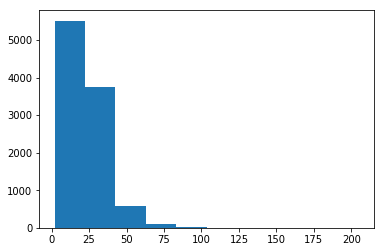

In [16]:
# Get distribution of the number of words per sentence

L3_split['totalwords'] = [len(x.split()) for x in L3_split['text'].tolist()]


plt.hist(L3_split["totalwords"])
plt.show()

In [17]:
# Word count of longest sentence

max(L3_split['totalwords'])

205

In [18]:
L3_split.shape

(9987, 3)

In [17]:
## Now doing final preprocessing steps to get the data ready for BERT

L3_df = pd.read_csv('L3train_nonOneHot_7topics.csv')
L3_df.head()

,Unnamed: 0,text,category
0,0,The Economic Effects of Abortion Access: A Rev...,pro-choice
1,0,Highlights A large body of research has examin...,pro-choice
2,0,A number of studies have also established asso...,pro-choice
3,0,This paper summarizes a smaller body of litera...,pro-choice
4,0,Educational attainment: Abortion access reduce...,pro-choice


In [18]:
L3_df.category.unique()

array(['pro-choice', 'pro-immigration', 'pro-guns', 'anti-spending',
       'anti-immigration', 'oppose-medicare', 'pro-life', 'pro-free',
       'pro-medicare', 'tax-wealthy', 'anti-tax-wealthy', 'anti-guns',
       'anti-free', 'pro-spending'], dtype=object)

In [19]:
label_dict = {'pro-immigration':0, 'pro-guns':1, 'anti-immigration':2,'oppose-medicare':3, 
              'pro-medicare':4, 'anti-guns':5, 'pro-choice':6, 'pro-life':7,
              'pro-free':8, 'anti-free':9, 'pro-spending':10, 'anti-spending':11,
              'tax-wealthy': 12, 'anti-tax-wealthy':13}

In [20]:
L3_df['category'] = L3_df.category.apply(lambda x: label_dict[x])
L3_df = shuffle(L3_df,random_state = 100)
L3_df.head()

,Unnamed: 0,text,category
3351,13,The US doesn’t just sell military arsenals.,11
9904,8,"Under current plans, the Army will recruit an ...",10
1839,0,"Whatever label you attach to their strategy, t...",1
5681,6,"Otherwise, the money will have to be allocated...",8
3624,5,Open immigration policies and efforts do not a...,2


In [21]:
L3_df = pd.DataFrame({
    'id':range(len(L3_df)),
    'label':L3_df['category'],
    'alpha':['a']*L3_df.shape[0],
    'text': L3_df['text']
})

L3_df.head()

,id,label,alpha,text
3351,0,11,a,The US doesn’t just sell military arsenals.
9904,1,10,a,"Under current plans, the Army will recruit an ..."
1839,2,1,a,"Whatever label you attach to their strategy, t..."
5681,3,8,a,"Otherwise, the money will have to be allocated..."
3624,4,2,a,Open immigration policies and efforts do not a...


In [22]:
cutoff = math.floor(len(L3_df) * 0.9)
print(cutoff)

train_df = L3_df[:cutoff]
dev_df = L3_df[cutoff:]
print('Rows in Training:', train_df.shape[0])
print('Rows in Dev:', dev_df.shape[0])

8988
Rows in Training: 8988
Rows in Dev: 999


In [23]:
train_df.to_csv('train.tsv', sep='\t', header=True, index=False, columns=train_df.columns)
dev_df.to_csv('dev.tsv', sep='\t', header=True, index=False, columns=dev_df.columns)

# Test data
We apply a similar methodology on our test data

In [2]:
def preprocess_df(csv):
    candidate_name = csv.split('_')[0]
    
    df = pd.read_csv(csv)
    df['text'] = df['text'].apply(lambda x: tokenize.sent_tokenize(x))
    df = pd.DataFrame({'text':np.concatenate(df.text.values)}).reindex()
    df["text"] = df["text"].apply(lambda x: x.replace('\n', ' '))
    df = df[df.text.str.len() > 10]
    df.to_csv(candidate_name + "_test2.csv")
    

In [3]:
preprocess_df("Biden_cleaned2.csv")
preprocess_df("Sanders_cleaned2.csv")
preprocess_df("Buttigieg_cleaned2.csv")
preprocess_df("Yang_cleaned2.csv")
preprocess_df("Warren_cleaned2.csv")
preprocess_df("Klobuchar_cleaned2.csv")

In [24]:
def preprocess_test(candidate):
    df = pd.read_csv('%s_test2.csv' % candidate, lineterminator='\n')
    df.columns = ['id','text']
    df.to_csv('%s.tsv' % candidate, sep='\t', header=True, index=False, columns=df.columns)
    
def preprocess_trump():
    df = pd.read_csv('trump_tweets.csv').reset_index()
    df.columns = ['id','text']
    df.to_csv('Trump.tsv', sep='\t', header=True, index=False, columns=df.columns)

In [25]:
preprocess_trump()
preprocess_test('Biden')
preprocess_test('Sanders')
preprocess_test('Buttigieg')
preprocess_test('Klobuchar')
preprocess_test('Warren')
preprocess_test('Yang')